In [1]:
import os

In [ ]:
!pip install -U tensorflow==2.10.1
import keras
print(keras.__version__)

In [3]:
version = "ResnetV1"

In [4]:
config_str = \
"""
input:
  image_input_path: "/kaggle/input/firedetectiondataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET"
  image_size: [128,128]
  batch_size: 8
  validation_split: 0.2
  use_resnet: True

output:
  result_path: "../results"
  viz_path: "../visualizations"
  logging_path: "/kaggle/working/"
"""

In [5]:
import yaml
import sys

def output_to_file(filename):
    orig_stdout = sys.stdout
    f = open(filename, "w")
    sys.stdout = f
    return orig_stdout, f

def output_as_before(std_orig, file):
    sys.stdout = std_orig
    file.close()
    
def read_config(PATH_CONFIG = "../config.yml", file = True):
    if file:
        with open(PATH_CONFIG, "r") as file:
            config = yaml.safe_load(file)
    else:
        config = yaml.safe_load(PATH_CONFIG)
    return config

def get_available_devices():
    print(tf.config.list_physical_devices("GPU"))

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory
def read_images_from_dir2(path_images, image_size, batch_size, validation_split = None):
    def separate_features_labels(features, labels):
        features = tf.stack(list(features), axis = 1)
        return features, labels
    
    if validation_split:
        ds_train, ds_val = image_dataset_from_directory(path_images,
                                          labels = "inferred",
                                          label_mode = "categorical",
                                          class_names = ["fire", "Smoke", "non fire"] ,
                                          batch_size=batch_size,
                                          image_size = image_size,
                                          #shuffle = True,
                                          subset = "both",
                                      validation_split = validation_split,
                                                        seed = 42
                                         ) # not supported,  pad_to_aspect_ratio = True)
        #AUTOTUNE = tf.data.AUTOTUNE

        #ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
        #ds_val = ds_val.cache().prefetch(buffer_size = AUTOTUNE)
        #ds_train = tf.data.Dataset.from_tensor_slices(list(ds_train))
        #ds_val = tf.data.Dataset.from_tensor_slices(list(ds_val))
        #ds_train = ds_train.map(separate_features_labels)
        #ds_val = ds_val.map(separate_features_labels)

        return ds_train, ds_val
    else:
        ds = image_dataset_from_directory(path_images,
                                          labels = "inferred",
                                          label_mode = "categorical",
                                          class_names = ["fire", "Smoke", "non fire"] ,
                                          batch_size=batch_size,
                                          image_size = image_size,
                                          #shuffle = True
                                         ) # not supported,  pad_to_aspect_ratio = True)
        #AUTOTUNE = tf.data.AUTOTUNE
        #ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
        #ds = ds.map(separate_features_labels)
        #ds = tf.data.Dataset.from_tensor_slices(list(ds))
        return ds

In [7]:
from keras.layers import RandomFlip, RandomRotation
def get_aug_model(augment = False):
    if not augment:
        return None
    
    data_aug_model = tf.keras.models.Sequential([
        RandomFlip("vertical"),
        RandomRotation(0.2)#not too  much
    ])
    return data_aug_model

In [8]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input, Rescaling
#import keras.applications.resnet
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions

class FireDetectionModel(tf.keras.Model):
    def __init__(self, input_shape, use_resnet = False):
        super().__init__()
        self.custom_input_shape = input_shape
        self.use_resnet = use_resnet
        self.custom_model = self.create_model()

    def create_model(self):
        if self.use_resnet:
            base_model = ResNet50(weights = "imagenet",
                            include_top = False,
                            input_shape = self.custom_input_shape)
            base_model.trainable = False
            
            inputs = Input(shape = self.custom_input_shape)
            x = base_model(inputs, training= False)
            x = keras.layers.GlobalAveragePooling2D()(x)
            outputs= Dense(3, activation = "softmax")(x)
            model = keras.Model(inputs, outputs)
            
        else:
            model = tf.keras.models.Sequential([
                Rescaling(1/255, input_shape = self.custom_input_shape),
                Conv2D(64, (3,3), activation = "relu", name = "conv1", padding = "same"),
                BatchNormalization(),
                MaxPooling2D(2,2),
                Dropout(0.4),
                Conv2D(128, (3,3), activation = "relu", name = "conv2", padding = "same"),
                BatchNormalization(),
                MaxPooling2D(2,2),
                Dropout(0.5),
                Flatten(),
                Dense(128, activation = "relu"),
                Dropout(0.4),
                Dense(3, activation="softmax")
            ])
        return model

    def call(self, x):
        return self.custom_model(x)


In [9]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
def test_fire_initial(version):
    
    print(get_available_devices())
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    
    

    config = read_config(config_str, False)
    #create_all_dirs(config)
    image_input_path = config["input"]["image_input_path"]
    viz_output_path = config["output"]["viz_path"]
    logging_path = config["output"]["logging_path"]
    image_size = config["input"]["image_size"]
    batch_size = config["input"]["batch_size"]
    validation_split = config["input"]["validation_split"]
    use_resnet = config["input"]["use_resnet"]
    print(use_resnet)

    filename = version + "_Run.txt"
    std_orig, file = output_to_file(os.path.join(logging_path, filename))

    train_ds, val_ds = read_images_from_dir2(os.path.join(image_input_path, "train"), image_size = image_size, batch_size = batch_size, validation_split=validation_split)
    test_ds = read_images_from_dir2(os.path.join(image_input_path, "test"), image_size = image_size, batch_size = batch_size)
    print(type(train_ds))
    print(type(test_ds))
    print(type(val_ds))
    aug_model = get_aug_model(augment = False)
    if aug_model:
        print("augmenting dataset")
        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.map(lambda x, y: (aug_model(x), y), num_parallel_calls=AUTOTUNE)
    #elif use_resnet:
    #    print(type(train_ds))
    #    train_ds = preprocess_input(train_ds)
    #    test_ds = preprocess_input(test_ds)
    

    model = FireDetectionModel(input_shape = (image_size[0], image_size[1], 3), use_resnet = use_resnet)
    model.build(input_shape = (None,image_size[0], image_size[1], 3))
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.summary(expand_nested = True)
    keras.utils.plot_model(model, show_shapes = True, expand_nested = True)
    
    if use_resnet:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights = True),
            ModelCheckpoint(version + '_model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.keras', save_weights_only = True, save_best_only=True, monitor='val_loss', mode='min')
        ]
    else:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights = True),
            ModelCheckpoint(version + '_model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.keras', save_best_only=True, monitor='val_loss', mode='min')
        ]
        

    hist = model.fit(train_ds, validation_data=val_ds, epochs = 30, callbacks = callbacks)
    print("Test Accuracy: " + str(model.evaluate(test_ds)))
    output_as_before(std_orig, file)
    
    #plot("accuracy")
    #plot("categorical_crossentropy")
    
    return hist

In [10]:
hist = test_fire_initial(version)

[]
None
True


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


In [11]:
import matplotlib.pyplot as plt
def plot(hist, value, model_name):
    res = hist.history
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Epoch")
    plt.plot(hist.epoch, res[value], label = "Train " + str(value))
    plt.plot(hist.epoch, res["val_" + value], label = "Val " + str(value))
    plt.legend()
    plt.savefig(f"/kaggle/working/plot_{value}_{model_name}.png")
    plt.show()

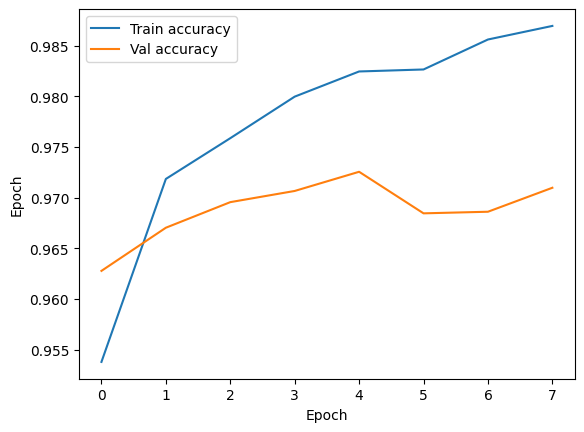

In [12]:
plot(hist, "accuracy", version)

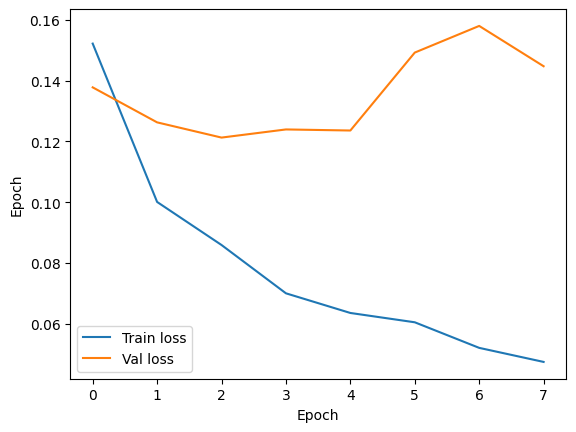

In [13]:
plot(hist, "loss", version)